In [1]:
import os
import string
import numpy as np
import pandas as pd
from FlowCytometryTools import ThresholdGate, PolyGate
from matplotlib import pyplot as plt
from matplotlib import cm
from flow import importF

/usr/local/lib/python3.7/dist-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)
/usr/local/lib/python3.7/dist-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)


In [2]:
path_ = os.path.abspath('')

In [3]:
sample1A, _ = importF(path_ + "/data/PBMC-rec-quant/04-23/Plate 1/Plate 1 - Panel 1 IL2R/", "A")
sample2B, _ = importF(path_ + "/data/PBMC-rec-quant/04-23/Plate 1/Plate 1 - Panel 2 IL2R/", "B")
sample3C, _ = importF(path_ + "/data/PBMC-rec-quant/04-23/Plate 1/Plate 1 - Panel 3 IL2R/", "C")

In [4]:
def combineWells(samples, channels_):
    """Accepts sample array returned from importF, and array of channels, returns transformed combined well data"""
    combinedSamples = samples[0]
    for sample in samples[1:]:
        combinedSamples.data = combinedSamples.data.append(sample.data)
    t_combinedSamples = combinedSamples.transform('tlog', channels=channels_)
    return t_combinedSamples

In [5]:
sample_all = combineWells(sample1A, ["FSC-H", "SSC-H", "SSC-A", 'VL6-H', 'VL4-H', 'BL1-H', 'VL1-H', 'BL3-H'])
sample_all.data = sample_all.data.append(combineWells(sample2B, ["FSC-H", "SSC-H", "SSC-A", 'VL6-H', 'VL4-H', 'BL1-H', 'VL1-H', 'BL3-H']).data)
sample_all.data = sample_all.data.append(combineWells(sample3C, ["FSC-H", "SSC-H", "SSC-A", 'VL6-H', 'VL4-H', 'BL1-H', 'VL1-H', 'BL3-H']).data)

/usr/local/lib/python3.7/dist-packages/FlowCytometryTools/core/transforms.py:80: RuntimeWarning: invalid value encountered in log10
  return where(x <= th, log10(th) * 1. * r / d, log10(x) * 1. * r / d)


## A) Preliminary Gating - Singlet Lymphocytes

Text(0.5, 1.0, 'All Events')

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


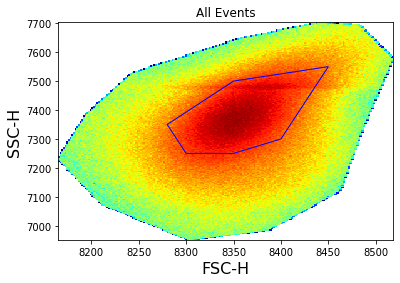

In [6]:
lymphocyte_gate = PolyGate([(8300, 7250), (8350, 7250), (8400, 7300), (8450, 7550), (8350, 7500), (8280, 7350)], ('FSC-H', 'SSC-H'), region='in', name='nk')
_ = sample_all.plot(["FSC-H", "SSC-H"], gates=lymphocyte_gate, cmap=cm.jet)
plt.title("All Events")

<FCMeasurement 'Test Sample0'>

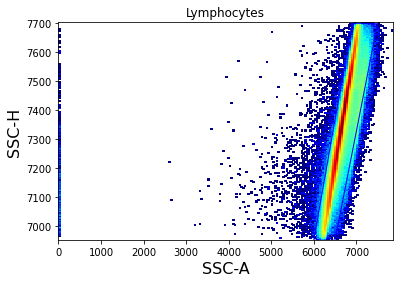

In [7]:
sample_all.gate(lymphocyte_gate)
singlet_gate = PolyGate([(6000, 6950), (6900, 7700), (7500, 7700), (6500, 6950)], ('SSC-A', 'SSC-H'), region='in', name='nk')
_ = sample_all.plot(["SSC-A","SSC-H"], gates=singlet_gate, cmap=cm.jet)
plt.title("Lymphocytes")
sample_all.gate(singlet_gate)

## C) T helper and T regulatory cells

Text(0, 0.5, 'CD4')

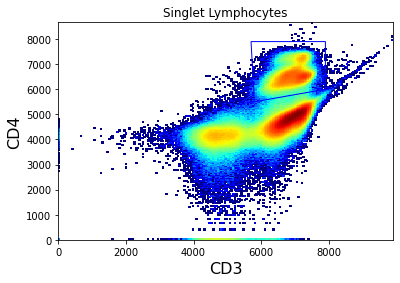

In [8]:
cd3cd4_gate = PolyGate([(5.5e03, 5.8e03), (6.0e03, 7.9e03), (7.9e03, 7.9e03), (7.9e03, 5.7e03)], ('VL6-H', 'VL4-H'), region='in', name='cd3cd4')
_ = sample_all.plot(['VL4-H','VL6-H'], gates=cd3cd4_gate, cmap=cm.jet) #CD3, CD4
plt.title("Singlet Lymphocytes")
plt.xlabel("CD3")
plt.ylabel("CD4")

Text(0, 0.5, 'CD127')

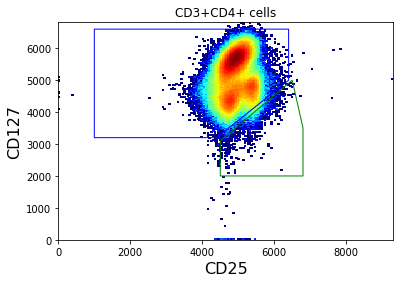

In [9]:
samplecd3cd4 = sample_all.gate(cd3cd4_gate)
thelp_gate = PolyGate([(3.2e03, 1e03), (3.2e03, 4.4e03), (5.0e03, 6.4e03), (6.6e03, 6.4e03), (6.6e03, 1e03)], ('BL1-H', 'VL1-H'), region='in', name='thelp')
treg_gate = PolyGate([(3.1e03, 4.5e03), (5.0e03, 6.5e03), (3.5e03, 6.8e03), (2.0e3, 6.8e03), (2.0e3, 4.5e03)], ('BL1-H', 'VL1-H'), region='in', name='treg')
_ = samplecd3cd4.plot(['VL1-H','BL1-H'], gates=[thelp_gate,treg_gate], cmap=cm.jet) #CD3, CD4
plt.title("CD3+CD4+ cells")
plt.xlabel("CD25")
plt.ylabel("CD127")

In [10]:
samplethelp = samplecd3cd4.gate(thelp_gate)
sampletreg = samplecd3cd4.gate(treg_gate)

Text(0.5, 1.0, 'T helper')

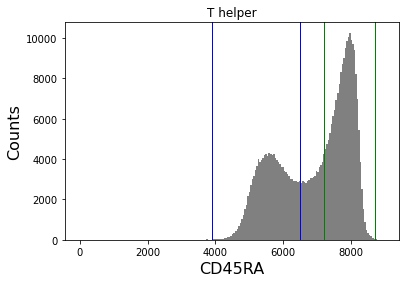

In [11]:
memthelpgate = ThresholdGate(6500.0, ['BL3-H'], region='below') & ThresholdGate(3900.0, ['BL3-H'], region='above')
naivethelpgate = ThresholdGate(7200.0, ['BL3-H'], region='above') & ThresholdGate(8700.0, ['BL3-H'], region='below')
_ = samplethelp.plot(['BL3-H'], gates=[memthelpgate,naivethelpgate])
plt.xlabel("CD45RA")
plt.title("T helper")

Text(0.5, 1.0, 'T reg')

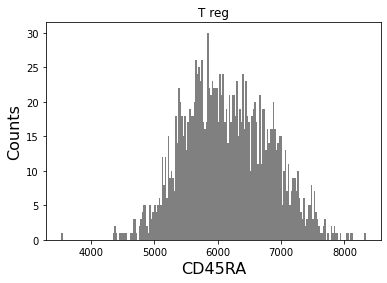

In [12]:
_ = sampletreg.plot(['BL3-H'])
plt.xlabel("CD45RA")
plt.title("T reg")

Not sure about naive/memory gates based on histogram

## D) NK Cells

Percent NK gated:  14.75242961400453 %
Percent NKT gated:  2.4563913622521256 %


Text(0, 0.5, 'CD56')

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


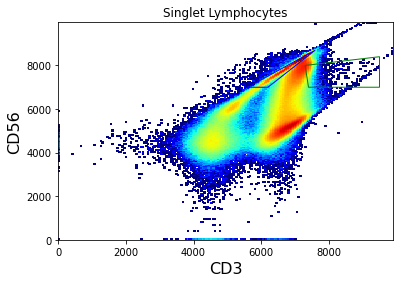

In [13]:
nk_gate = PolyGate([(5600, 7000), (6200, 7000), (7600, 8700)], ('VL4-H', 'BL3-H'), region='in', name='nk')
nkt_gate = PolyGate([(7300, 8000), (7400, 7000), (9500, 7000), (9500, 8400)], ('VL4-H', 'BL3-H'), region='in', name='nkt')
_ = sample_all.plot(['VL4-H', 'BL3-H'], gates=[nk_gate,nkt_gate], cmap=cm.jet) #CD56 vs. CD3
samplenk = sample_all.gate(nk_gate)
samplenkt = sample_all.gate(nkt_gate)
print("Percent NK gated: ", samplenk.counts/sample_all.counts*100., "%")
print("Percent NKT gated: ", samplenkt.counts/sample_all.counts*100., "%")
plt.title("Singlet Lymphocytes")
plt.xlabel("CD3")
plt.ylabel("CD56")

Try normalizing with side scatter:

Text(0, 0.5, 'CD56')

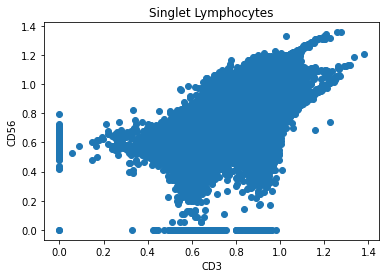

In [14]:
y = sample_all['BL3-H'] / sample_all['SSC-H']
x = sample_all['VL4-H'] / sample_all['SSC-H']
plt.rcParams['agg.path.chunksize'] = 10000
plt.scatter(x, y) # doesn't fix shape
plt.title("Singlet Lymphocytes")
plt.xlabel("CD3")
plt.ylabel("CD56")

## E) CD8+ T cells

Text(0, 0.5, 'CD8')

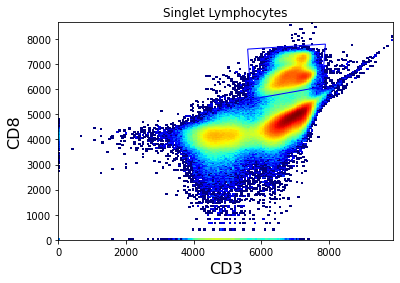

In [15]:
cd8_gate = PolyGate([(5700, 5600), (5600, 7600), (7900, 7800), (7800, 6100)], ('VL4-H', 'VL6-H'), region='in', name='cd8')
_ = sample_all.plot(['VL4-H', 'VL6-H'], gates=cd8_gate, cmap=cm.jet) #CD8 vs. CD3
plt.title("Singlet Lymphocytes")
plt.xlabel("CD3")
plt.ylabel("CD8")

Text(0.5, 1.0, 'CD3+CD8+ Cytotoxic T cells')

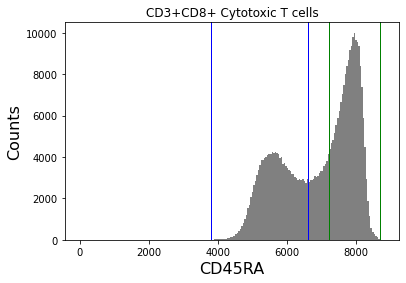

In [16]:
cd3cd8sample = sample_all.gate(cd8_gate)
memcd3cd8gate = ThresholdGate(6600.0, ['BL3-H'], region='below') & ThresholdGate(3800.0, ['BL3-H'], region='above')
naivecd3cd8gate = ThresholdGate(7200.0, ['BL3-H'], region='above') & ThresholdGate(8700.0, ['BL3-H'], region='below')
_ = cd3cd8sample.plot(['BL3-H'], gates=[memcd3cd8gate,naivecd3cd8gate])
plt.xlabel("CD45RA")
plt.title("CD3+CD8+ Cytotoxic T cells")